[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/daniel-dodd/gpjax_workshop/blob/main/regression.ipynb)

# Regression

In this notebook we demonstate how to fit a Gaussian process regression model.

In [1]:
!pip install gpjax==0.7.0

# Enable Float64 for more stable matrix inversions.
from jax.config import config

config.update("jax_enable_x64", True)

from jax import jit, value_and_grad
import jax.numpy as jnp
import jax.random as jr
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

import gpjax as gpx

key = jr.PRNGKey(123)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

## Dataset

With the necessary modules imported, we simulate a dataset
$\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{100}$ with inputs $\boldsymbol{x}$
sampled uniformly on $(-3., 3)$ and corresponding independent noisy outputs

$$\boldsymbol{y} \sim \mathcal{N} \left(\sin(4\boldsymbol{x}) + \cos(2 \boldsymbol{x}), \textbf{I} * 0.3^2 \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs and labels
for later.

In [2]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

To better understand what we have simulated, we plot both the underlying latent
function and the observed data that is subject to Gaussian noise.

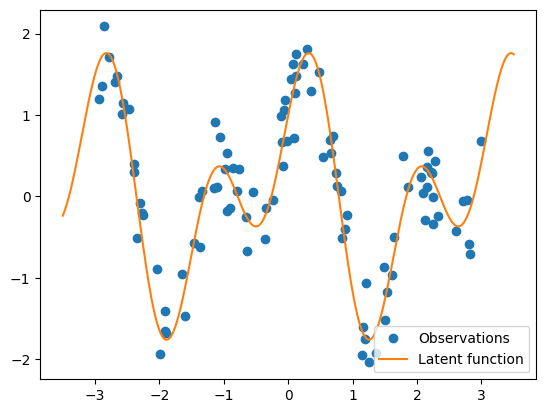

In [3]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

Our aim in this tutorial will be to reconstruct the latent function from our noisy
observations $\mathcal{D}$ via Gaussian process regression. We begin by defining a
Gaussian process prior in the next section.

## Defining the prior

A zero-mean Gaussian process (GP) places a prior distribution over real-valued
functions $f(\cdot)$ where
$f(\boldsymbol{x}) \sim \mathcal{N}(0, k(\boldsymbol{x}, \boldsymbol{x}) )$
for any finite collection of inputs $\boldsymbol{x}$, and 

$$k(\boldsymbol{x}, \boldsymbol{x}) = \begin{bmatrix} k(x_1, x_1) & \cdots & k(x_1, x_n) \\ \vdots & \ddots & \vdots \\ k(x_n, x_1) & \cdots & k(x_n, x_n) \end{bmatrix}$$


The choice of kernel function is critical as, among other things, it governs the
smoothness of the outputs that our GP can generate.

For simplicity, we consider a radial basis function (RBF) kernel:
$$k(x, x') = \sigma^2 \exp\left(-\frac{\lVert x - x' \rVert_2^2}{2 \ell^2}\right).$$

On paper a GP is written as $f(\cdot) \sim \mathcal{GP}(\textbf{0}, k(\cdot, \cdot'))$,
we can reciprocate this process in GPJax via defining a `Prior` with our chosen `RBF`
kernel.

In [4]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)


The above construction forms the foundation for GPJax's models. Moreover, the GP prior
we have just defined can be represented by a
[TensorFlow Probability](https://www.tensorflow.org/probability/api_docs/python/tfp/substrates/jax)
multivariate Gaussian distribution. Such functionality enables trivial sampling, and
the evaluation of the GP's mean and covariance .

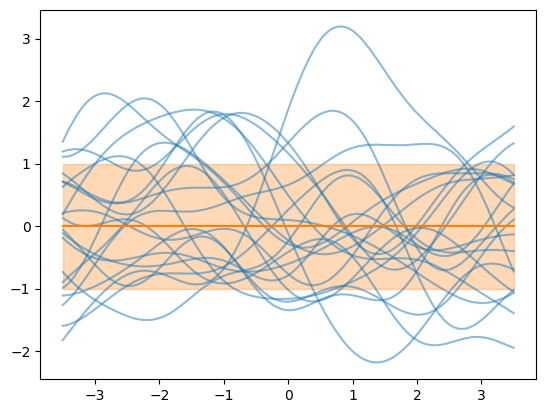

In [5]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)

## Constructing the posterior

Having defined our GP, we proceed to define a description of our data
$\mathcal{D}$ conditional on our knowledge of $f(\cdot)$ --- this is exactly the
notion of a likelihood function $p(\mathcal{D} | f(\cdot))$. While the choice of
likelihood is a critical in Bayesian modelling, for simplicity we consider a
Gaussian with noise parameter $\alpha$
$$p(\mathcal{D} | f(\cdot)) = \mathcal{N}(\boldsymbol{y}; f(\boldsymbol{x}), \textbf{I} \alpha^2).$$
This is defined in GPJax through calling a `Gaussian` instance.

In [6]:
likelihood = gpx.Gaussian(num_datapoints=D.n)

The posterior is proportional to the prior multiplied by the likelihood, written as

  $$ p(f(\cdot) | \mathcal{D}) \propto p(f(\cdot)) * p(\mathcal{D} | f(\cdot)). $$

Mimicking this construct, the posterior is established in GPJax through the `*` operator.

In [7]:
posterior = prior * likelihood

## Hyperparameter optimisation
- Most kernels have several *hyperparameters*, which we denote $\mathbf{\theta}$, which encode different assumptions about the underlying function being modelled. For the our setting we have $\mathbf{\theta} = \{\alpha^2, \ell^2, \sigma^2\}$. 
- Fully Bayesian approach to dealing with hyperparameters would be to place a prior over them, and marginalise over the posterior derived from the data in order to perform predictions. However, this is often computationally very expensive, and so a common approach is to instead *optimise* the hyperparameters by maximising the log marginal likelihood:

$$ \begin{aligned}
\log(p(\boldsymbol{y} | \boldsymbol{x}, \boldsymbol{\theta})) &= \log\left(\int p(\boldsymbol{y} | \mathbf{f}, \boldsymbol{x}, \boldsymbol{\theta}) p(\mathbf{f} | \mathbf{x}, \boldsymbol{\theta}) d\mathbf{f}\right) \nonumber \\
&= - \frac{1}{2} \boldsymbol{y} ^ \top \left(k(\boldsymbol{x}, \boldsymbol{x}) + \sigma^2 \mathbf{I} \right)^{-1} \boldsymbol{y} - \frac{1}{2} \log |k(\boldsymbol{x}, \boldsymbol{x}) + \sigma^2 \mathbf{I}| - \frac{n}{2} \log 2 \pi
\end{aligned}$$

In [8]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

Array(124.80517341, dtype=float64)

In [9]:
value_and_grad(negative_mll)(posterior, train_data=D)

(Array(124.80517341, dtype=float64),
 ConjugatePosterior(prior=Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(13.14432312, dtype=float64, weak_type=True), variance=Array(-1.85682611, dtype=float64, weak_type=True)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=100, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(26.62727768, dtype=float64, weak_type=True)), jitter=1e-06))

For researchers, GPJax has the capacity to print the bibtex citation for objects such
as the marginal log-likelihood through the `cite()` function.

In [10]:
print(gpx.cite(negative_mll))

@book{rasmussen2006gaussian,
authors = {Rasmussen, Carl Edward and Williams, Christopher K},
title = {Gaussian Processes for Machine Learning},
year = {2006},
publisher = {MIT press Cambridge, MA},
volume = {2},
}


In [11]:
negative_mll = jit(negative_mll)

We can now define an optimiser with `optax`. For this example we'll use the `adam`
optimiser.

In [12]:
# Tranform model to unconstrained space.
posterior = posterior.unconstrain()

# Define optimiser.
optim = ox.adam(learning_rate=0.01)
optim_state = optim.init(posterior)

# Define history.
history = []

# Optimise!
for step in range(500):
    value, grads = value_and_grad(negative_mll)(posterior.constrain(), D)
    updates, optim_state = optim.update(grads, optim_state, posterior)
    posterior = ox.apply_updates(posterior, updates)
    history.append(value)


# Constrain model back to original space.
posterior = posterior.constrain()

We can plot the training loss to see how the optimisation has
progressed.

[Text(0.5, 0, 'Training iteration'),
 Text(0, 0.5, 'Negative marginal log likelihood')]

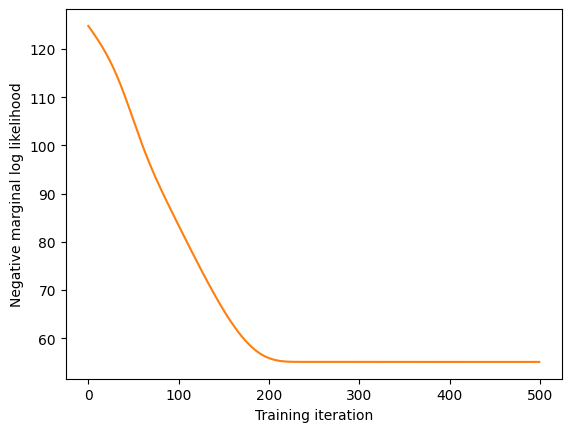

In [13]:
fig, ax = plt.subplots()
ax.plot(history, color=cols[1])
ax.set(xlabel="Training iteration", ylabel="Negative marginal log likelihood")

## Prediction

Equipped with the posterior and a set of optimised hyperparameter values, we are now
in a position to query our GP's predictive distribution at novel test inputs. To do
this, we use our defined `posterior` and `likelihood` at our test inputs to obtain
the predictive distribution as a `Distrax` multivariate Gaussian upon which `mean`
and `stddev` can be used to extract the predictive mean and standard deviatation.

In [14]:
latent_dist = posterior.predict(xtest, train_data=D)
predictive_dist = posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

With the predictions and their uncertainty acquired, we illustrate the GP's
performance at explaining the data $\mathcal{D}$ and recovering the underlying
latent function of interest.

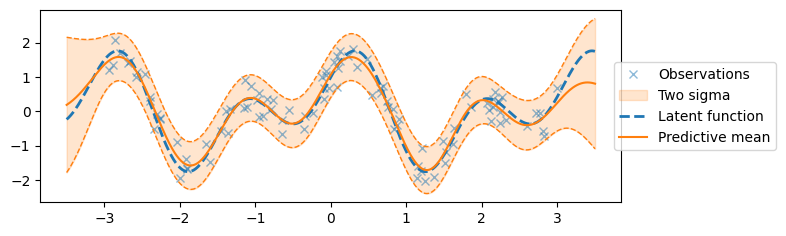

In [15]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))